# Neural Networks

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
train_dataset = h5py.File('train_signs.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:]) 
y_train = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_signs.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:]) 
y_test = np.array(test_dataset["test_set_y"][:])

In [3]:
X_train = np.reshape(x_train, (x_train.shape[0], -1))
Y_train = np.reshape(np.eye(6)[y_train],(-1,6))

X_test = np.reshape(x_test, (x_test.shape[0], -1))
Y_test = np.reshape(np.eye(6)[y_test],(-1,6))

It's a 5


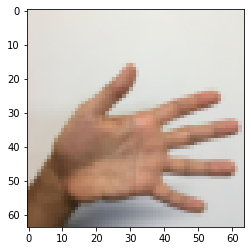

In [4]:
index = 0
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's a {}".format(y_train[index]))

In [5]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []

    def __call__(self, inputs):
        return inputs/255.
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.tanh(u)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        v = tf.transpose(z)
        u = tf.math.exp(v)
        return u/tf.math.reduce_sum(u, axis=1, keepdims=True)

In [6]:
class LossFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(tf.math.reduce_mean(y_true*tf.math.log(y_pred), axis=1), axis=0)

In [7]:
class MetricFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        maximum = tf.math.reduce_max(y_pred, axis=1, keepdims=True)
        y_pred_ = tf.sign(1+tf.sign(y_pred-maximum))
        return tf.math.reduce_mean(tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_)), axis=1), axis=0) 

In [8]:
class Optimizer():
    
    def __init__(self, model, learning_rate, batch_size):
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.stop_training = False
        
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            weights[i].assign(w - self.learning_rate*grad_w)
            
    def train_step(self, X, Y):
        num_batches = X.shape[0]//self.batch_size
        for batch in range(num_batches+1):
            if batch<num_batches:
                X_batch = X[batch*self.batch_size:(batch+1)*self.batch_size,:]
                Y_batch = Y[batch*self.batch_size:(batch+1)*self.batch_size,:]
            else:
                X_batch = X[batch:,:]
                Y_batch = Y[batch:,:]
            with tf.GradientTape() as tape:
                H = self.model(X_batch)
                loss = self.model.loss(Y_batch, H)
            grads = tape.gradient(loss, self.model.weights)
            self.apply(grads, self.model.weights)    
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [9]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [10]:
class NN():
    
    def __init__(self, dims):
        self.dims = dims
        self.build()
    
    def build(self):
        self.layers = []
        self.layers.append(Layer1(model=self, input_dim=self.dims[0], output_dim=self.dims[0]))
        for i in range(len(self.dims)-2):
            self.layers.append(Layer2(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1]))
        self.layers.append(Layer3(model=self, input_dim=self.dims[-2], output_dim=self.dims[-1]))
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        y = inputs
        for layer in self.layers:
            y = layer(y)
        return y 
        
    def train_setup(self, epochs, learning_rate, batch_size, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, batch_size=self.batch_size)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, batch_size=64, verbose=True):
        self.train_setup(epochs, learning_rate, batch_size, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [11]:
nn = NN(dims=[X_train.shape[1], 32, 32, Y_train.shape[1]])

nn.fit(X_train, Y_train)

Train on 1080 samples
Epochs 1/1000 - Loss: 0.2987496256828308 - Metric: 0.7225304245948792
----- 0.451s -----
Epochs 2/1000 - Loss: 0.2987033426761627 - Metric: 0.7225304245948792
----- 0.247s -----
Epochs 3/1000 - Loss: 0.2986600399017334 - Metric: 0.7225304245948792
----- 0.262s -----
Epochs 4/1000 - Loss: 0.2986185848712921 - Metric: 0.7222217917442322
----- 0.233s -----
Epochs 5/1000 - Loss: 0.2985782325267792 - Metric: 0.7222217917442322
----- 0.243s -----
Epochs 6/1000 - Loss: 0.29853805899620056 - Metric: 0.7222217917442322
----- 0.323s -----
Epochs 7/1000 - Loss: 0.29849761724472046 - Metric: 0.7225304245948792
----- 0.274s -----
Epochs 8/1000 - Loss: 0.2984563112258911 - Metric: 0.7225304245948792
----- 0.225s -----
Epochs 9/1000 - Loss: 0.29841360449790955 - Metric: 0.7228390574455261
----- 0.258s -----
Epochs 10/1000 - Loss: 0.2983684539794922 - Metric: 0.7228390574455261
----- 0.25s -----
Epochs 11/1000 - Loss: 0.2983197569847107 - Metric: 0.7228390574455261
----- 0.277s -

----- 0.243s -----
Epochs 92/1000 - Loss: 0.29292336106300354 - Metric: 0.7685180902481079
----- 0.249s -----
Epochs 93/1000 - Loss: 0.2928197681903839 - Metric: 0.7688267230987549
----- 0.25s -----
Epochs 94/1000 - Loss: 0.2927146553993225 - Metric: 0.7688267230987549
----- 0.261s -----
Epochs 95/1000 - Loss: 0.2926079034805298 - Metric: 0.7688267230987549
----- 0.245s -----
Epochs 96/1000 - Loss: 0.29249945282936096 - Metric: 0.7694439888000488
----- 0.251s -----
Epochs 97/1000 - Loss: 0.29238930344581604 - Metric: 0.7694439888000488
----- 0.24s -----
Epochs 98/1000 - Loss: 0.29227733612060547 - Metric: 0.7703699469566345
----- 0.255s -----
Epochs 99/1000 - Loss: 0.29216358065605164 - Metric: 0.7709872126579285
----- 0.249s -----
Epochs 100/1000 - Loss: 0.2920479476451874 - Metric: 0.7716045379638672
----- 0.251s -----
Epochs 101/1000 - Loss: 0.2919304072856903 - Metric: 0.7716045379638672
----- 0.265s -----
Epochs 102/1000 - Loss: 0.2918109595775604 - Metric: 0.7716045379638672
----

----- 0.289s -----
Epochs 182/1000 - Loss: 0.27307429909706116 - Metric: 0.7811724543571472
----- 0.304s -----
Epochs 183/1000 - Loss: 0.2727088928222656 - Metric: 0.7811724543571472
----- 0.297s -----
Epochs 184/1000 - Loss: 0.2723407745361328 - Metric: 0.7811723947525024
----- 0.298s -----
Epochs 185/1000 - Loss: 0.2719699740409851 - Metric: 0.7811723947525024
----- 0.282s -----
Epochs 186/1000 - Loss: 0.2715964913368225 - Metric: 0.7820983529090881
----- 0.298s -----
Epochs 187/1000 - Loss: 0.2712204158306122 - Metric: 0.7827156186103821
----- 0.259s -----
Epochs 188/1000 - Loss: 0.27084189653396606 - Metric: 0.7827156186103821
----- 0.264s -----
Epochs 189/1000 - Loss: 0.2704608738422394 - Metric: 0.7827156186103821
----- 0.263s -----
Epochs 190/1000 - Loss: 0.2700774073600769 - Metric: 0.7824069261550903
----- 0.261s -----
Epochs 191/1000 - Loss: 0.2696916460990906 - Metric: 0.7827155590057373
----- 0.257s -----
Epochs 192/1000 - Loss: 0.2693036198616028 - Metric: 0.78302419185638

----- 0.253s -----
Epochs 272/1000 - Loss: 0.2373792827129364 - Metric: 0.7913575172424316
----- 0.259s -----
Epochs 273/1000 - Loss: 0.23702113330364227 - Metric: 0.7910488843917847
----- 0.256s -----
Epochs 274/1000 - Loss: 0.23666435480117798 - Metric: 0.7910489439964294
----- 0.252s -----
Epochs 275/1000 - Loss: 0.2363089621067047 - Metric: 0.7916662096977234
----- 0.272s -----
Epochs 276/1000 - Loss: 0.23595494031906128 - Metric: 0.7925921678543091
----- 0.27s -----
Epochs 277/1000 - Loss: 0.2356022745370865 - Metric: 0.79351806640625
----- 0.291s -----
Epochs 278/1000 - Loss: 0.23525099456310272 - Metric: 0.793826699256897
----- 0.26s -----
Epochs 279/1000 - Loss: 0.23490098118782043 - Metric: 0.7950612306594849
----- 0.288s -----
Epochs 280/1000 - Loss: 0.23455233871936798 - Metric: 0.7959871888160706
----- 0.267s -----
Epochs 281/1000 - Loss: 0.23420491814613342 - Metric: 0.7969130873680115
----- 0.273s -----
Epochs 282/1000 - Loss: 0.2338588535785675 - Metric: 0.79814767837524

----- 0.267s -----
Epochs 362/1000 - Loss: 0.20877628028392792 - Metric: 0.8342588543891907
----- 0.238s -----
Epochs 363/1000 - Loss: 0.2084774225950241 - Metric: 0.8351848125457764
----- 0.258s -----
Epochs 364/1000 - Loss: 0.20817862451076508 - Metric: 0.8358020782470703
----- 0.285s -----
Epochs 365/1000 - Loss: 0.20787981152534485 - Metric: 0.8358020782470703
----- 0.256s -----
Epochs 366/1000 - Loss: 0.20758101344108582 - Metric: 0.8354933857917786
----- 0.255s -----
Epochs 367/1000 - Loss: 0.2072821706533432 - Metric: 0.8358020782470703
----- 0.263s -----
Epochs 368/1000 - Loss: 0.2069832980632782 - Metric: 0.836728036403656
----- 0.269s -----
Epochs 369/1000 - Loss: 0.2066843956708908 - Metric: 0.8373452425003052
----- 0.262s -----
Epochs 370/1000 - Loss: 0.20638544857501984 - Metric: 0.8379625678062439
----- 0.262s -----
Epochs 371/1000 - Loss: 0.20608647167682648 - Metric: 0.8385798931121826
----- 0.26s -----
Epochs 372/1000 - Loss: 0.20578747987747192 - Metric: 0.83888852596

----- 0.253s -----
Epochs 452/1000 - Loss: 0.18143261969089508 - Metric: 0.8719132542610168
----- 0.264s -----
Epochs 453/1000 - Loss: 0.18112316727638245 - Metric: 0.8719132542610168
----- 0.368s -----
Epochs 454/1000 - Loss: 0.18081362545490265 - Metric: 0.8725305199623108
----- 0.281s -----
Epochs 455/1000 - Loss: 0.18050412833690643 - Metric: 0.8734564781188965
----- 0.268s -----
Epochs 456/1000 - Loss: 0.18019457161426544 - Metric: 0.8737650513648987
----- 0.27s -----
Epochs 457/1000 - Loss: 0.17988501489162445 - Metric: 0.8737650513648987
----- 0.271s -----
Epochs 458/1000 - Loss: 0.17957545816898346 - Metric: 0.8746910095214844
----- 0.273s -----
Epochs 459/1000 - Loss: 0.17926587164402008 - Metric: 0.8746910095214844
----- 0.276s -----
Epochs 460/1000 - Loss: 0.17895634472370148 - Metric: 0.8753083348274231
----- 0.272s -----
Epochs 461/1000 - Loss: 0.17864680290222168 - Metric: 0.8753083348274231
----- 0.277s -----
Epochs 462/1000 - Loss: 0.17833729088306427 - Metric: 0.875925

----- 0.263s -----
Epochs 542/1000 - Loss: 0.15412139892578125 - Metric: 0.8978392481803894
----- 0.278s -----
Epochs 543/1000 - Loss: 0.1538308560848236 - Metric: 0.8978392481803894
----- 0.261s -----
Epochs 544/1000 - Loss: 0.15354077517986298 - Metric: 0.8981478214263916
----- 0.255s -----
Epochs 545/1000 - Loss: 0.15325117111206055 - Metric: 0.8981478214263916
----- 0.253s -----
Epochs 546/1000 - Loss: 0.15296205878257751 - Metric: 0.8987650871276855
----- 0.273s -----
Epochs 547/1000 - Loss: 0.15267334878444672 - Metric: 0.8987651467323303
----- 0.264s -----
Epochs 548/1000 - Loss: 0.1523851454257965 - Metric: 0.8987651467323303
----- 0.278s -----
Epochs 549/1000 - Loss: 0.1520974338054657 - Metric: 0.8993824124336243
----- 0.273s -----
Epochs 550/1000 - Loss: 0.1518101841211319 - Metric: 0.8993824124336243
----- 0.258s -----
Epochs 551/1000 - Loss: 0.1515233963727951 - Metric: 0.8993824124336243
----- 0.279s -----
Epochs 552/1000 - Loss: 0.1512371152639389 - Metric: 0.89938241243

----- 0.262s -----
Epochs 632/1000 - Loss: 0.12999224662780762 - Metric: 0.9194441437721252
----- 0.262s -----
Epochs 633/1000 - Loss: 0.1297474056482315 - Metric: 0.9203701019287109
----- 0.291s -----
Epochs 634/1000 - Loss: 0.129503071308136 - Metric: 0.9203701019287109
----- 0.335s -----
Epochs 635/1000 - Loss: 0.12925918400287628 - Metric: 0.9206787347793579
----- 0.315s -----
Epochs 636/1000 - Loss: 0.12901580333709717 - Metric: 0.9206787347793579
----- 0.289s -----
Epochs 637/1000 - Loss: 0.12877286970615387 - Metric: 0.9209873676300049
----- 0.25s -----
Epochs 638/1000 - Loss: 0.12853041291236877 - Metric: 0.9209873676300049
----- 0.246s -----
Epochs 639/1000 - Loss: 0.12828843295574188 - Metric: 0.9209873676300049
----- 0.255s -----
Epochs 640/1000 - Loss: 0.128046914935112 - Metric: 0.9212960004806519
----- 0.246s -----
Epochs 641/1000 - Loss: 0.12780584394931793 - Metric: 0.9212960004806519
----- 0.268s -----
Epochs 642/1000 - Loss: 0.12756524980068207 - Metric: 0.92160463333

----- 0.264s -----
Epochs 722/1000 - Loss: 0.10955454409122467 - Metric: 0.9330244064331055
----- 0.257s -----
Epochs 723/1000 - Loss: 0.10934161394834518 - Metric: 0.9336417317390442
----- 0.247s -----
Epochs 724/1000 - Loss: 0.1091289222240448 - Metric: 0.9336417317390442
----- 0.25s -----
Epochs 725/1000 - Loss: 0.10891648381948471 - Metric: 0.9339504241943359
----- 0.256s -----
Epochs 726/1000 - Loss: 0.10870429128408432 - Metric: 0.9342590570449829
----- 0.258s -----
Epochs 727/1000 - Loss: 0.10849233716726303 - Metric: 0.9342590570449829
----- 0.249s -----
Epochs 728/1000 - Loss: 0.10828066617250443 - Metric: 0.9342590570449829
----- 0.254s -----
Epochs 729/1000 - Loss: 0.10806924849748611 - Metric: 0.9345676302909851
----- 0.251s -----
Epochs 730/1000 - Loss: 0.1078580915927887 - Metric: 0.9345676302909851
----- 0.247s -----
Epochs 731/1000 - Loss: 0.10764718055725098 - Metric: 0.9345676302909851
----- 0.254s -----
Epochs 732/1000 - Loss: 0.10743656754493713 - Metric: 0.93487626

----- 0.262s -----
Epochs 812/1000 - Loss: 0.09184088557958603 - Metric: 0.9484565854072571
----- 0.259s -----
Epochs 813/1000 - Loss: 0.09165968745946884 - Metric: 0.9487652778625488
----- 0.254s -----
Epochs 814/1000 - Loss: 0.09147869050502777 - Metric: 0.9487652778625488
----- 0.253s -----
Epochs 815/1000 - Loss: 0.09129784256219864 - Metric: 0.949073851108551
----- 0.254s -----
Epochs 816/1000 - Loss: 0.09111717343330383 - Metric: 0.9493825435638428
----- 0.258s -----
Epochs 817/1000 - Loss: 0.09093668311834335 - Metric: 0.9496912360191345
----- 0.262s -----
Epochs 818/1000 - Loss: 0.09075634181499481 - Metric: 0.9499997496604919
----- 0.255s -----
Epochs 819/1000 - Loss: 0.09057620167732239 - Metric: 0.9503085613250732
----- 0.258s -----
Epochs 820/1000 - Loss: 0.09039618819952011 - Metric: 0.9503085613250732
----- 0.255s -----
Epochs 821/1000 - Loss: 0.09021634608507156 - Metric: 0.9506171345710754
----- 0.253s -----
Epochs 822/1000 - Loss: 0.09003666043281555 - Metric: 0.950925

----- 0.228s -----
Epochs 902/1000 - Loss: 0.07635948807001114 - Metric: 0.9620369076728821
----- 0.231s -----
Epochs 903/1000 - Loss: 0.07620082795619965 - Metric: 0.9620369076728821
----- 0.251s -----
Epochs 904/1000 - Loss: 0.07604246586561203 - Metric: 0.9620369076728821
----- 0.253s -----
Epochs 905/1000 - Loss: 0.07588455826044083 - Metric: 0.9620369076728821
----- 0.255s -----
Epochs 906/1000 - Loss: 0.07572700828313828 - Metric: 0.9623456001281738
----- 0.257s -----
Epochs 907/1000 - Loss: 0.07556990534067154 - Metric: 0.9623456001281738
----- 0.256s -----
Epochs 908/1000 - Loss: 0.07541317492723465 - Metric: 0.9623456001281738
----- 0.254s -----
Epochs 909/1000 - Loss: 0.0752568244934082 - Metric: 0.9623456001281738
----- 0.256s -----
Epochs 910/1000 - Loss: 0.0751008614897728 - Metric: 0.962654173374176
----- 0.26s -----
Epochs 911/1000 - Loss: 0.07494533807039261 - Metric: 0.9626542925834656
----- 0.255s -----
Epochs 912/1000 - Loss: 0.07479017227888107 - Metric: 0.962654292

----- 0.253s -----
Epochs 992/1000 - Loss: 0.06352075934410095 - Metric: 0.970370352268219
----- 0.248s -----
Epochs 993/1000 - Loss: 0.06339081376791 - Metric: 0.970370352268219
----- 0.259s -----
Epochs 994/1000 - Loss: 0.06326111406087875 - Metric: 0.970370352268219
----- 0.272s -----
Epochs 995/1000 - Loss: 0.06313154846429825 - Metric: 0.970370352268219
----- 0.27s -----
Epochs 996/1000 - Loss: 0.06300216913223267 - Metric: 0.970370352268219
----- 0.257s -----
Epochs 997/1000 - Loss: 0.06287308037281036 - Metric: 0.970370352268219
----- 0.251s -----
Epochs 998/1000 - Loss: 0.06274405866861343 - Metric: 0.970370352268219
----- 0.255s -----
Epochs 999/1000 - Loss: 0.0626152902841568 - Metric: 0.970370352268219
----- 0.26s -----
Epochs 1000/1000 - Loss: 0.0624866709113121 - Metric: 0.970370352268219
----- 0.265s -----


In [12]:
nn.evaluate(X_train, Y_train)

Loss: 0.0624866709113121 - Metric: 0.970370352268219


[0.06248667, 0.97037035]

In [13]:
nn.evaluate(X_test, Y_test)

Loss: 0.09860927611589432 - Metric: 0.927777886390686


[0.098609276, 0.9277779]

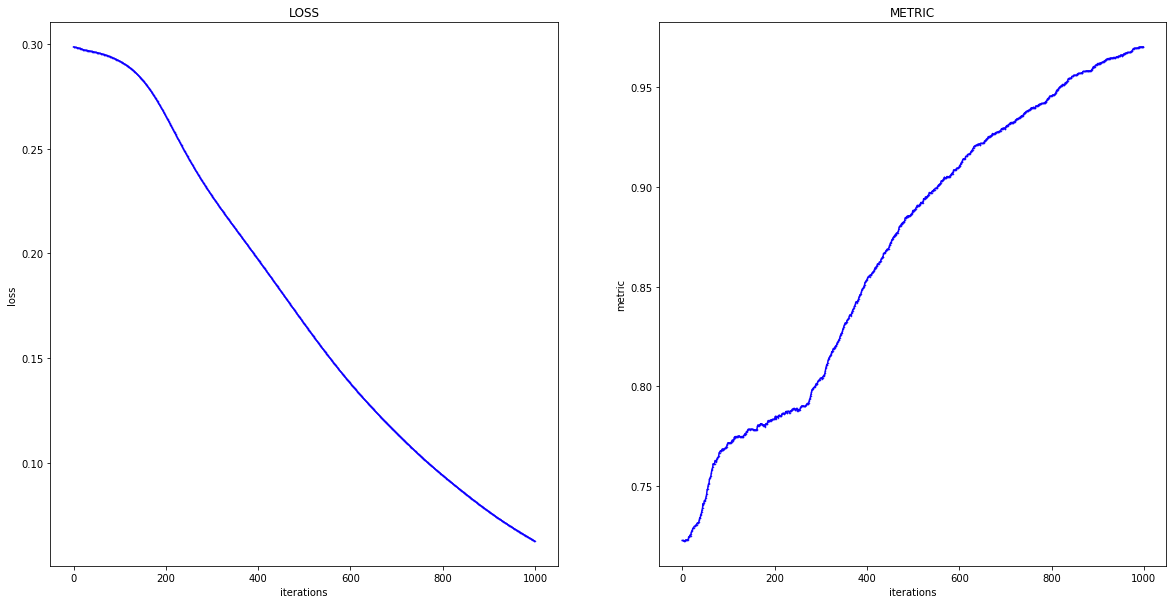

In [14]:
loss = nn.history['loss']
metric = nn.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

It's a 5


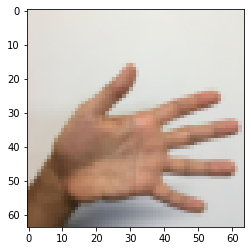

In [15]:
index = 0
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's a {}".format(np.argmax(nn.predict(X_train[[index],:]))))